# A*

This is adapted from the given intro_coppelia file from near the beginning of Lehigh University's Mobile Robotics course.

In [1]:
# Import the python library that connects to CoppeliaSim, the file is sim.py.
try:
    import sim
except:
    print('--------------------------------------------------------------')
    print('"sim.py" could not be imported. This means very probably that')
    print('either "sim.py" or the remoteApi library could not be found.')
    print('Make sure both are in the same folder as this file,')
    print('or appropriately adjust the file "sim.py"')
    print('--------------------------------------------------------------')
    print('')

import time
import numpy as np

%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Check if python is connecting to Coppelia

In [2]:
print('Program started')
sim.simxFinish(-1)  # just in case, close all opened connections
clientID = sim.simxStart('127.0.0.1', 19999, True, True, 5000, 5)  # Connect to CoppeliaSim

if clientID != -1:
    print('Connected to remote API server')

    # Now try to retrieve data in a blocking fashion (i.e. a service call):
    res, objs = sim.simxGetObjects(clientID, sim.sim_handle_all, sim.simx_opmode_blocking)

    # Before closing the connection to CoppeliaSim, make sure that the last command sent out had time to arrive. You can guarantee this with (for example):
    sim.simxGetPingTime(clientID)

    # Now close the connection to CoppeliaSim:
    sim.simxFinish(clientID)
else:
    print('Failed connecting to remote API server')
print('Program ended')

Program started
Connected to remote API server
Program ended


# Object oriented programming

In [3]:
class robot():
    
    def __init__(self, motor_names, frame_name=None):        
        self.client_id = self.open_connection()
        self.motors = self._get_handlers(motor_names) 
        
        # Robot frame
        self.frame = self._get_handler(frame_name)
        
        #Dummy
        self.dummy_handle = None
            
        
    def open_connection(self):
        sim.simxFinish(-1)  # just in case, close all opened connections
        self.client_id = sim.simxStart('127.0.0.1', 19999, True, True, 5000, 5)  # Connect to CoppeliaSim 
        
        if clientID != -1:
            print('Robot connected')
        else:
            print('Connection failed')
        return clientID
        
    def close_connection(self):    
        sim.simxGetPingTime(self.client_id)  # Before closing the connection to CoppeliaSim, make sure that the last command sent out had time to arrive.
        sim.simxFinish(self.client_id)  # Now close the connection to CoppeliaSim:
        print('Connection closed')
    
    def isConnected(self):
        c,result = sim.simxGetPingTime(self.client_id)
        # Return true if the robot is connected
        return result > 0         
        
    def _get_handler(self, name):
        err_code, handler = sim.simxGetObjectHandle(self.client_id, name, sim.simx_opmode_blocking)
        return handler
    
    def _get_handlers(self, names):
        handlers = []
        for name in names:
            handler = self._get_handler(name)
            handlers.append(handler)
        
        return handlers

    def send_motor_velocities(self, vels):
        for motor, vel in zip(self.motors, vels):
            err_code = sim.simxSetJointTargetVelocity(self.client_id, 
                                                      motor, vel, sim.simx_opmode_streaming)      
            
    def set_position(self, position, relative_object):
        relative_handle = self._get_handler(relative_object)
        sim.simxSetObjectPosition(clientID, self.frame, relative_handle, position, sim.simx_opmode_oneshot)
    
    def get_position(self, relative_object=-1):
        if relative_object != -1:
            relative_object = self.get_handler(relative_object)
        res, position = sim.simxGetObjectPosition(self.client_id, self.frame, relative_object, sim.simx_opmode_blocking)
        return array(position)
    
    def get_object_position(self, object_name):
        err_code, object_h = sim.simxGetObjectHandle(self.client_id, object_name, sim.simx_opmode_blocking)
        res, position = sim.simxGetObjectPosition(self.client_id, object_h, -1, sim.simx_opmode_blocking)
        return array(position)
    
    def get_object_relative_position(self, object_name):
        err_code, object_h = sim.simxGetObjectHandle(self.client_id, object_name, sim.simx_opmode_blocking)
        res, position = sim.simxGetObjectPosition(self.client_id, object_h, self.frame, sim.simx_opmode_blocking)
        return array(position)
    
    def get_self_length(self):
        err_code, object_h = sim.simxGetObjectHandle(self.client_id, 'Omnirob_body', sim.simx_opmode_blocking)
        #res, yMin = sim.simxGetObjectIntParameter(self.client_id, object_h, 16, sim.simx_opmode_blocking)
        res, yMax = sim.simxGetObjectIntParameter(self.client_id, object_h, 25, sim.simx_opmode_blocking)
        
        return (yMax * 2)
    
    def move_dummy(self, position):
        #add dummy if does not exist
        if self.dummy_handle is None:
            res, self.dummy_handle = sim.simxCreateDummy(self.client_id, 1, None, sim.simx_opmode_blocking)
        
        #move dummy to position
        sim.simxSetObjectPosition(clientID, self.dummy_handle, -1, position, sim.simx_opmode_oneshot)
        
    def get_dummy_relative_position(self):
        position = [0, 0, 0]
        if self.dummy_handle is not None:
            res, position = sim.simxGetObjectPosition(self.client_id, self.dummy_handle, self.frame, sim.simx_opmode_blocking)
        return array(position)
    
    #For cuboid plotting: Get minimum and maximum x and y bounding box coords
    #using simxGetObjectIntParameter(clientID, objectHandle, parameterID, sim.simx_opmode_blocking)
    #where parameterID is 15 for minX, 18 for maxX, 16 for minY, and 19 for maxY.
    #Subtract minY from maxY to get height, subtract minX from maxX to get width.
    #Add global object origin position to minX and minY to get absolute positions of that corner.
    #Get rotation relative to world frame about Z axis.
    #Return minX, minY, width, height, rotation.
    def get_cuboid_plotting_data(self, object_name):
        err_code, object_h = sim.simxGetObjectHandle(self.client_id, object_name, sim.simx_opmode_blocking)
        #global position
        res, position = sim.simxGetObjectPosition(self.client_id, object_h, -1, sim.simx_opmode_blocking)
        position.pop()
        #get rotation
        res, rotation=sim.simxGetObjectOrientation(clientID, object_h, -1, sim.simx_opmode_blocking)
        rotation = rotation[2]
        
        return rotation, position
    
    def get_cylinder_plotting_data(self, object_name):
        err_code, object_h = sim.simxGetObjectHandle(self.client_id, object_name, sim.simx_opmode_blocking)
        #global position
        res, position = sim.simxGetObjectPosition(self.client_id, object_h, -1, sim.simx_opmode_blocking)
        position.pop()
        #radius
        res, radius = sim.simxGetObjectFloatParameter(clientID, object_h, 18, sim.simx_opmode_blocking)
        
        return position, radius

In [4]:
#Rotation function from stackoverflow user Mark Dickenson at this link: 
#https://stackoverflow.com/questions/34372480/rotate-point-about-another-point-in-degrees-python
def rotate(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return qx, qy

def get_cuboid_obstacle(cuboidName,r):
    rotation, center = r.get_cuboid_plotting_data(cuboidName)
    circles = []
    obstacle = []
    circles.append([center[0] - 1.5, center[1]])
    circles.append([center[0] - .5, center[1]])
    circles.append([center[0] + .5, center[1]])
    circles.append([center[0] + 1.5, center[1]])
    #rotate circles by rotation
    for circle in circles:
        x, y = rotate(center, circle, rotation)
        obstacle.append([x, y])
    
    return obstacle

def get_cylinder_obstacle(cylinderName,r):
    position, radius = r.get_cylinder_plotting_data(cylinderName)
    cylinders = []
    cylinders.append([position[0], position[1]])

    return cylinders

# Construct Map of Scene

Now, we can construct a map of the scene using the robot class, as long as we know what all the scene obstacles are named.

In [5]:
#First, we get the obstacle and goal coordinates

# Joint names in coppelia for KUKA omnidirectional robot
motor_names = ['Omnirob_FLwheel_motor', 'Omnirob_FRwheel_motor', 'Omnirob_RRwheel_motor', 'Omnirob_RLwheel_motor']

r = robot(motor_names, 'Omnirob')  # Create an instance of our robot

#get robot position
robotXY = r.get_position().tolist()
robotXY.pop()
#get robot length
robotLength = r.get_self_length()

#get goal position
goal = r.get_object_position('Sphere9').tolist()
goal.pop()

#get obstacle positions
obstacles = []
obstacles += get_cuboid_obstacle("Cuboid0", r)
obstacles += get_cuboid_obstacle("Cuboid1", r)
obstacles += get_cuboid_obstacle("Cuboid3", r)
obstacles += get_cuboid_obstacle("Cuboid4", r)
obstacles += get_cuboid_obstacle("Cuboid6", r)
obstacles += get_cylinder_obstacle("Cylinder5", r)
obstacles += get_cylinder_obstacle("Cylinder6", r)
obstacles += get_cylinder_obstacle("Cylinder7", r)
obstacles += get_cylinder_obstacle("Cylinder8", r)
obstacles += get_cylinder_obstacle("Cylinder9", r)
obstacles += get_cylinder_obstacle("Cylinder10", r)
obstacles += get_cylinder_obstacle("Cylinder11", r)
obstacles += get_cylinder_obstacle("Cylinder12", r)

r.close_connection()

Robot connected
Connection closed


In [6]:
#Next, we plot the map without the discretization grid

from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

def get_obstacle_patches(obstacles, radius):
    obstacleList = []
    for obstacle in obstacles:
        obstacleList.append(Circle((obstacle[0], obstacle[1]), radius))
        
    obstaclePatches = PatchCollection(obstacleList, facecolor='k')
        
    return obstaclePatches

0


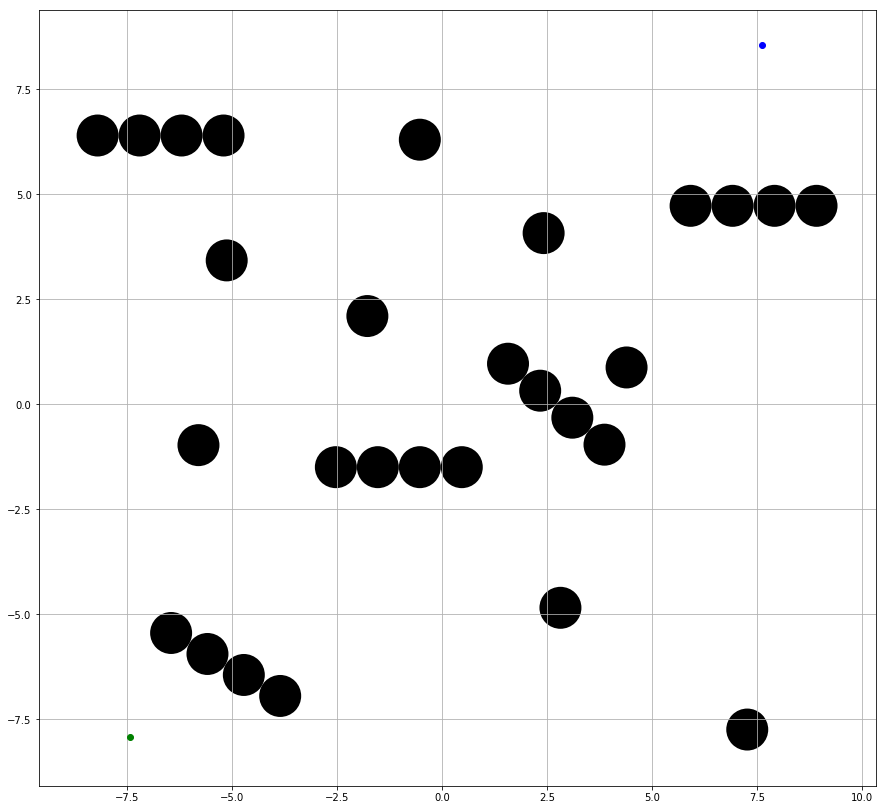

In [7]:
print(robotLength)

robotPatch = Circle((robotXY[0], robotXY[1]), (robotLength / 2) )
robotPatchCol = PatchCollection([robotPatch], facecolor='b')

preview_figure = plt.figure(figsize(15,15))
preview_show = preview_figure.add_subplot(111)

preview_show.add_collection(robotPatchCol)
preview_show.add_collection(get_obstacle_patches(obstacles, 0.5))
plt.plot(robotXY[0], robotXY[1], 'bo', goal[0], goal[1], 'go')

plt.grid()
preview_show.set_aspect('equal', adjustable='box')

# Discretizing the Space

Now we have a map of our space, with the robot marked in blue and the goal marked in green. We can now discretize this space into a graph of cells. Each cell containing an obstacle will be marked as untraversable, and any adjacent traversable cells will be connected via edges. This way, we will construct a graph that contains a path from the robot to the goal.

However, the current grid scale is too large, there does not exist a path from the start to the end. Let's reduce the scale of the grid so that we have smaller cells.

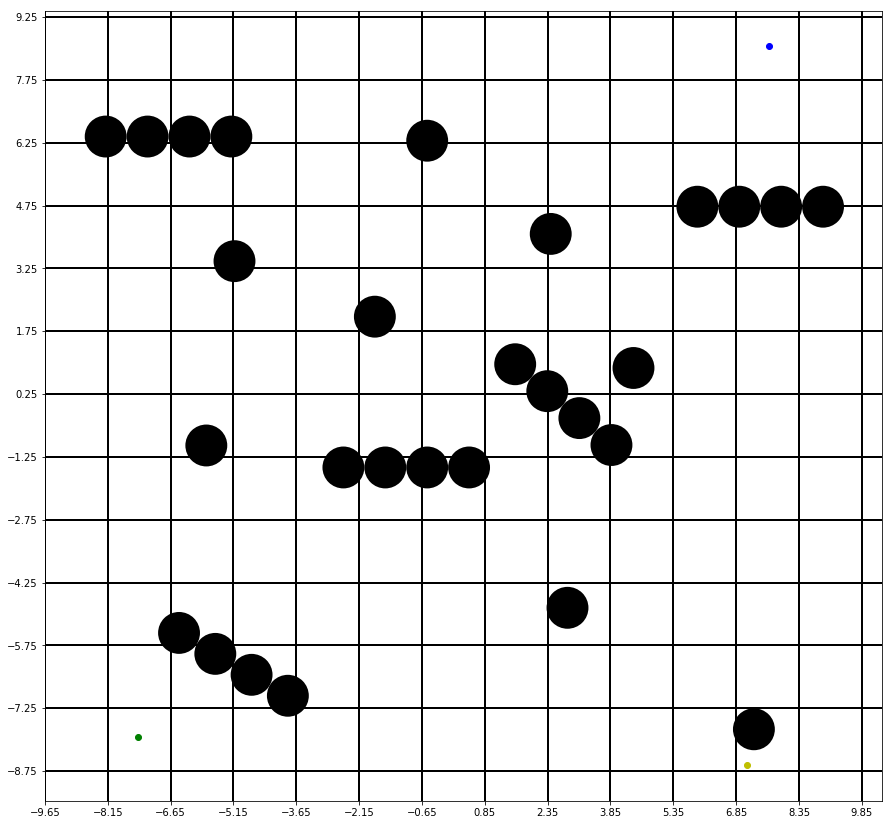

In [8]:
grainSize = 1.5

preview_figure = plt.figure(figsize(15,15))
preview_show = preview_figure.add_subplot(111)

preview_show.add_collection(get_obstacle_patches(obstacles, 0.5))
plt.plot(robotXY[0], robotXY[1], 'bo', goal[0], goal[1], 'go', 7.1, -8.6, 'yo')

plt.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
preview_show.set_xticks(np.arange(-9.65, 10, grainSize));
preview_show.set_yticks(np.arange(-8.75, 10, grainSize));
preview_show.set_aspect('equal', adjustable='box')

There is now a clear path to the objective that does not go through any obstacles. We can now simply black out the grid squares that intersect with an obstacle, and we'll be left with our graph.

[[0. 3. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0.]
 [0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0.]
 [0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0.]
 [0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1.]
 [1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1.]
 [1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0.]]


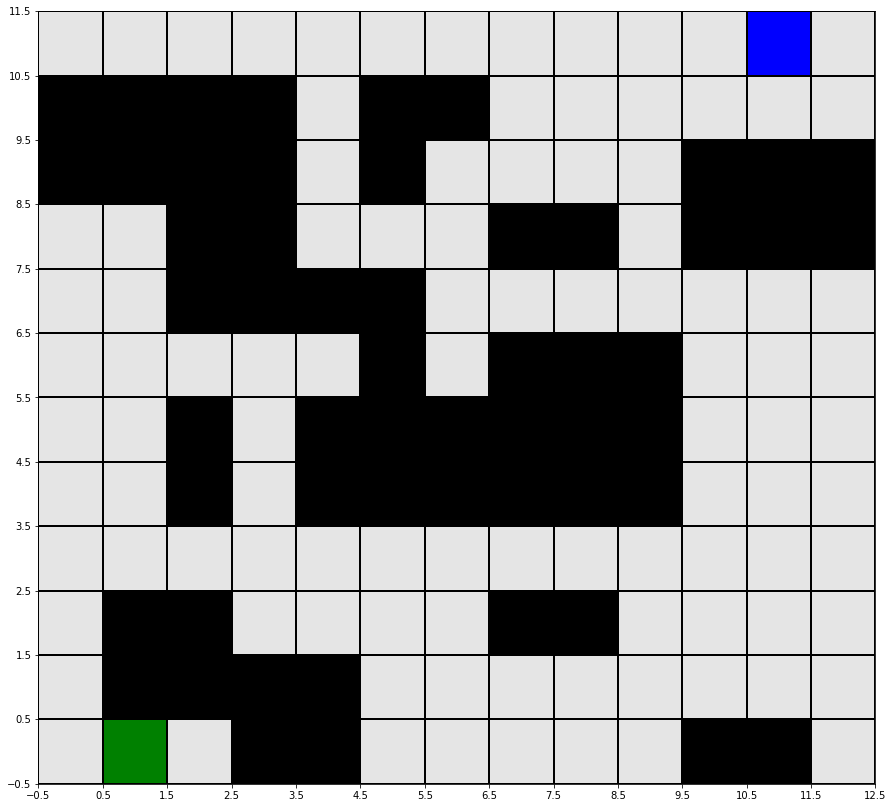

In [9]:
from matplotlib import colors

# This cell modified from Dr. David Saldana's code at this link:
# https://github.com/dsaldana/CSE360-MobileRobotics/blob/master/Grid_bfs.ipynb

# Create a matrix to represent the cells of the grid
grid_cells = np.zeros((12,13))
grid_cells[1,0] = 1
grid_cells[1,1] = 1
grid_cells[1,2] = 1
grid_cells[1,3] = 1
grid_cells[1,5] = 1
grid_cells[1,6] = 1
grid_cells[2,0] = 1
grid_cells[2,1] = 1
grid_cells[2,2] = 1
grid_cells[2,3] = 1
grid_cells[2,5] = 1
grid_cells[2,10] = 1
grid_cells[2,11] = 1
grid_cells[2,12] = 1
grid_cells[3,2] = 1
grid_cells[3,3] = 1
grid_cells[3,7] = 1
grid_cells[3,8] = 1
grid_cells[3,10] = 1
grid_cells[3,11] = 1
grid_cells[3,12] = 1
grid_cells[4,2] = 1
grid_cells[4,3] = 1
grid_cells[4,4] = 1
grid_cells[4,5] = 1
grid_cells[5,5] = 1
grid_cells[5,7] = 1
grid_cells[5,8] = 1
grid_cells[5,9] = 1
grid_cells[6,2] = 1
grid_cells[6,4] = 1
grid_cells[6,5] = 1
grid_cells[6,6] = 1
grid_cells[6,7] = 1
grid_cells[6,8] = 1
grid_cells[6,9] = 1
grid_cells[7,2] = 1
grid_cells[7,4] = 1
grid_cells[7,5] = 1
grid_cells[7,6] = 1
grid_cells[7,7] = 1
grid_cells[7,8] = 1
grid_cells[7,9] = 1
grid_cells[9,1] = 1
grid_cells[9,2] = 1
grid_cells[9,7] = 1
grid_cells[9,8] = 1
grid_cells[10,1] = 1
grid_cells[10,2] = 1
grid_cells[10,3] = 1
grid_cells[10,4] = 1
grid_cells[11,3] = 1
grid_cells[11,4] = 1
grid_cells[11,10] = 1
grid_cells[11,11] = 1
#Robot start pos and goal
grid_cells[0,11] = 2
grid_cells[11,1] = 3

grid_cells = np.flip(grid_cells, 0)

print(grid_cells)

# Plot the grid
def draw_grid():
    fig, ax = plt.subplots()
    cmap = colors.ListedColormap(['0.9', 'black', 'blue', 'green']) # Colors (0.9 is the almost white in gray scale)
    ax.imshow(grid_cells, cmap=cmap, origin='lower')
    ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
    ax.set_xticks(np.arange(-.5, 13, 1));
    ax.set_yticks(np.arange(-.5, 12, 1));

draw_grid()

# Creating a Graph from Discretized Space

Now that we have a nice even discrete grid, we must create a graph for it.

('Number of nodes in a full grid (13 * 12): ', 156)
('Number of nodes after removing obstacles: ', 101)
('Nodes:', NodeView(((11, 11), (7, 12), (0, 7), (1, 6), (3, 7), (2, 5), (1, 11), (8, 5), (4, 0), (10, 8), (11, 5), (10, 7), (7, 6), (6, 10), (4, 10), (3, 2), (2, 6), (5, 11), (6, 0), (11, 0), (0, 1), (3, 12), (1, 12), (3, 1), (2, 11), (9, 9), (7, 8), (3, 11), (8, 9), (4, 12), (2, 12), (9, 4), (5, 1), (11, 10), (1, 5), (3, 6), (1, 10), (8, 6), (4, 1), (10, 9), (9, 7), (6, 4), (11, 4), (10, 4), (7, 1), (6, 11), (11, 9), (0, 5), (1, 0), (0, 8), (4, 11), (3, 5), (5, 10), (10, 10), (6, 1), (11, 3), (0, 2), (3, 0), (9, 8), (8, 0), (6, 2), (7, 11), (3, 10), (5, 0), (0, 12), (3, 9), (2, 3), (1, 9), (9, 6), (5, 3), (11, 7), (7, 0), (11, 8), (0, 6), (1, 7), (0, 9), (3, 4), (2, 4), (8, 4), (10, 11), (6, 6), (11, 2), (7, 7), (3, 3), (2, 9), (8, 1), (5, 12), (10, 12), (6, 3), (11, 1), (7, 10), (0, 0), (2, 10), (6, 12), (11, 12), (7, 9), (3, 8), (2, 0), (1, 8), (4, 3), (11, 6))))


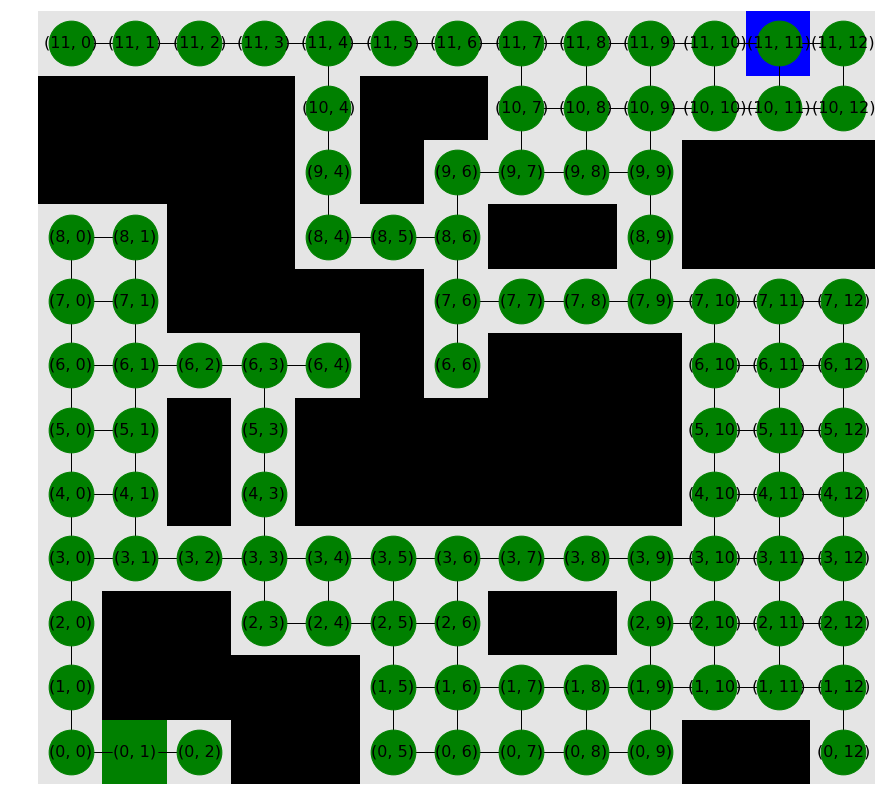

In [10]:
# This cell modified from Dr. David Saldana's code at this link:
# https://github.com/dsaldana/CSE360-MobileRobotics/blob/master/Grid_bfs.ipynb

import networkx as nx
# This function automatically creates the graph in a grid.
G = nx.grid_2d_graph(12, 13) 
print("Number of nodes in a full grid (13 * 12): ",len(G.nodes()))
# Delete nodes with obstacles
for i in range(12):
    for j in range(13):
        # if the node is an obstacle
        if grid_cells[i][j] == 1:  
            G.remove_node((i,j))

print("Number of nodes after removing obstacles: ",len(G.nodes()))
print("Nodes:", G.nodes())

# Position of the nodes
pos = {node:(node[1], node[0]) for node in G.nodes()}  # by making (x,y) = (j, i), where i and j iterate over the columns and the rows respectively.
draw_grid()
nx.draw(G, pos, font_size=16, with_labels=True, node_size=2000, node_color="g")


# A*

We can now use A* to get the shortest path between the start and end nodes.

[(11, 11), (10, 11), (10, 10), (10, 9), (9, 9), (8, 9), (7, 9), (7, 10), (6, 10), (5, 10), (4, 10), (3, 10), (3, 9), (3, 8), (3, 7), (3, 6), (3, 5), (3, 4), (3, 3), (3, 2), (3, 1), (3, 0), (2, 0), (1, 0), (0, 0), (0, 1)]


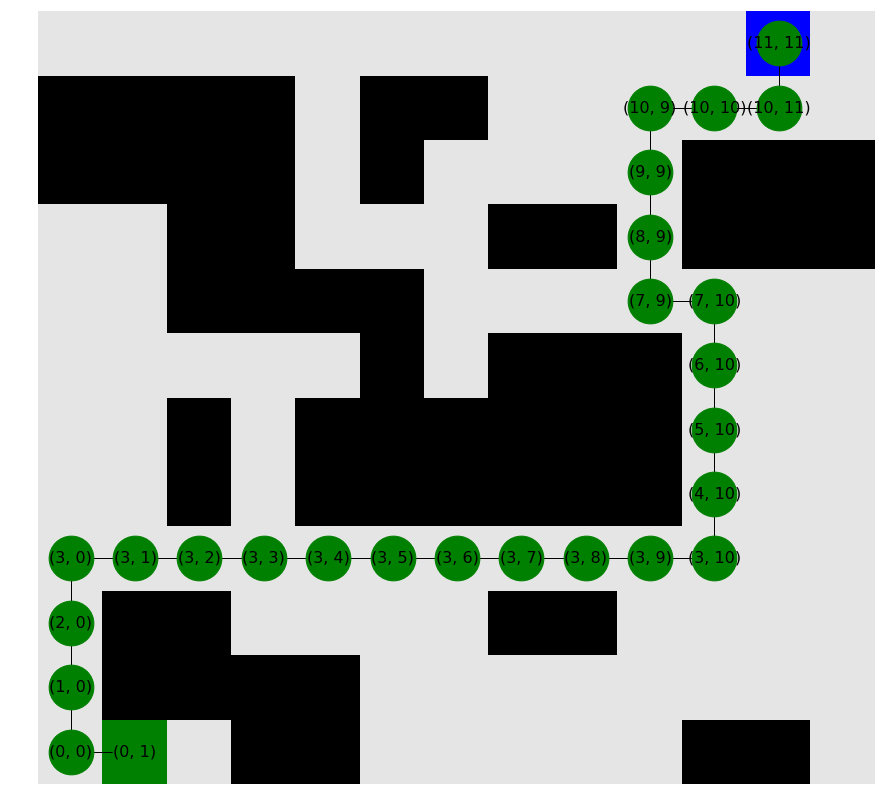

In [11]:
# This cell modified from Dr. David Saldana's code at this link:
# https://github.com/dsaldana/CSE360-MobileRobotics/blob/master/Grid_bfs.ipynb

#A* heuristic function (Euclidean distance)
def euclidean_distance(node1, node2):
    return sqrt((node1[0] - node2[0])**2 + (node1[1] - node2[1])**2)

#Networkx A* algorithm
path = nx.astar_path(G, (11,11), (0,1), euclidean_distance)

# Delete nodes not in path
for i in range(12):
    for j in range(13):
        # if the node is an obstacle
        if not G.has_node((i,j)):
            continue
        if (i,j) not in path:  
            G.remove_node((i,j))
pos = {node:(node[1], node[0]) for node in G.nodes()}  # by making (x,y) = (j, i), where i and j iterate over the columns and the rows respectively.
draw_grid()
nx.draw(G, pos, font_size=16, with_labels=True, node_size=2000, node_color="g")


print(path)

In [12]:
# Robot movement functions. Basic motor velocities for moving in the
# positive x axis and the positive y axis, can scale them and then combine them
# to move in any direction.

# Directional movement functions to move one node in the graph in any of four cardinal directions

def isClose(n1, n2):
    if abs(n1 - n2) < 0.05:
        return True
    else:
        return False

def move(xScale, yScale, r):
    motor_names = ['Omnirob_FLwheel_motor', 'Omnirob_FRwheel_motor', 'Omnirob_RRwheel_motor', 'Omnirob_RLwheel_motor']
    #basic x-axis movement
    xMotor = np.array([-1., -1., 1., 1.])
    yMotor = np.array([-1., 1., 1., -1.])
    r.send_motor_velocities(xScale * xMotor + yScale * yMotor)


    
def moveLeft(r):
    #Get current position for comparison, and start moving
    oldPos = r.get_position()
    
    r.move_dummy([oldPos[0] - 1.5, oldPos[1], 0])
    
    timeStep = 0
    while(timeStep < 500):
        #calculate if robot has reached destination yet, and correct for drift
        target = r.get_dummy_relative_position()
        move(5 * target[0], 5 * target[1], r)
        newPos = r.get_position()
        if(isClose(oldPos[0] - newPos[0], 1.5)):
            break
        time.sleep(0.01)
        timeStep += 1
            
    move(0, 0, r)
    return

def moveRight(r):
    #Get current position for comparison, and start moving
    oldPos = r.get_position()
    
    r.move_dummy([oldPos[0] + 1.5, oldPos[1], 0])
    
    timeStep = 0
    while(timeStep < 50):
        #calculate if robot has reached destination yet
        target = r.get_dummy_relative_position()
        move(5 * target[0], 5 * target[1], r)
        newPos = r.get_position()
        if(isClose(newPos[0] - oldPos[0], 1.5)):
            break
        time.sleep(0.1)
        timeStep += 0.01
            
    move(0, 0, r)
    return

def moveForward(r):
    #Get current position for comparison, and start moving
    oldPos = r.get_position()
    
    r.move_dummy([oldPos[0], oldPos[1] - 1.5, 0])
    
    timeStep = 0
    while(timeStep < 50):
        #calculate if robot has reached destination yet
        target = r.get_dummy_relative_position()
        move(5 * target[0], 5 * target[1], r)
        newPos = r.get_position()
        if(isClose(oldPos[1] - newPos[1], 1.5)):
            break
        time.sleep(0.1)
        timeStep += 0.01
            
    move(0, 0, r)
    return

def moveBackward(r):
    #Get current position for comparison, and start moving
    oldPos = r.get_position()
    
    r.move_dummy([oldPos[0], oldPos[1] + 1.5, 0])
    
    timeStep = 0
    while(timeStep < 50):
        target = r.get_dummy_relative_position()
        move(5 * target[0], 5 * target[1], r)
        #calculate if robot has reached destination yet
        newPos = r.get_position()
        if(isClose(newPos[1] - oldPos[1], 1.5)):
            break
        time.sleep(0.1)
        timeStep += 0.01
        
    move(0, 0, r)
    return

def nodeTransition(change, r):
    if change == (1,0):
        moveBackward(r)
    elif change == (-1, 0):
        moveForward(r)
    elif change == (0, 1):
        moveRight(r)
    elif change == (0, -1):
        moveLeft(r)

In [13]:
# Traverse path
r = robot(motor_names, 'Omnirob')  # Create an instance of our robot
for i in range(1, len(path)):
    change = (path[i][0] - path[i-1][0], path[i][1] - path[i-1][1])
    print(change)
    nodeTransition(change,r)
r.close_connection()

Robot connected
(-1, 0)
(0, -1)
(0, -1)
(-1, 0)
(-1, 0)
(-1, 0)
(0, 1)
(-1, 0)
(-1, 0)
(-1, 0)
(-1, 0)
(0, -1)
(0, -1)
(0, -1)
(0, -1)
(0, -1)
(0, -1)
(0, -1)
(0, -1)
(0, -1)
(0, -1)
(-1, 0)
(-1, 0)
(-1, 0)
(0, 1)
Connection closed
